## Starting Example
Here we will load the UR10 manipulator and load it into the Meshcat visualiser with a desired configuration. You should see a new window open in your browser displaying the arm in its default state.

In [226]:
import casadi
import numpy as np

import pinocchio as pin
import pinocchio.casadi as cpin

import time

from example_robot_data import load

robot = load('ur10')

# Select the default configuration for the robot.
q0 = robot.q0
# OPTIONAL - Instead, choose a random configuration within the configuration space of the model
# q0 = pin.randomConfiguration(robot.model)

## visualise the robot
import meshcat
from pinocchio.visualize import MeshcatVisualizer
viz = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
# Start a new MeshCat server and client.
viz.initViewer(open=True)
# Load the robot in the viewer.
viz.loadViewerModel()
# Display the robot with the initial state q0
viz.display(q0)

# Display reference as a transparent red model
viz_ref = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz_ref.initViewer(viz.viewer)
viz_ref.loadViewerModel(rootNodeName="reference", color=[1.0, 0.0, 0.0, 0.1])

# small time window for loading the model 
# if meshcat does not visualise the robot properly, augment the time
# it can be removed in most cases
time.sleep(0.2) 

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7011/static/


# Simulating the Dynamics Without Control
We will now use the rigid-body dynamics algorithms to forward-compute the dynamics of the robot from an initial state. When there is no joint stiffness or damping, the system will behave chaotically.

We are not accounting for collisions in this tutorial, as this would require a sophisticated physic simulator to handle the dynamics of contact, Meshcat is simply displaying the configuration of the robot.

In [227]:
# Control inputs to each joint of the robot (set to zero) 
u = np.zeros(robot.nq)

# Simulator step resolution (s)
dt = 0.001

# This is a very basic forward-simulator of the dynamics of the system given a control law controller, where the dynamics are forward-stepped by a first-order approximation.
def simulate(T, dt, robot, viz, viz_ref, reference, controller, fps = 30):
    frame_cnt = 0

    # nq - Dimension of the robots configuration vector q
    # nv - Dimension of the robots velocity and acceleration vectors (v, a)
    
    q = robot.q0 # Configuration vector q
    v = np.zeros(robot.nv) # Velocity vector v
    a = np.zeros(robot.nv) # Acceleration vector a

    # Determine number of steps to wait until next frame
    n_skip = int((1.0 / fps) / dt)

    t = 0
    while t <= T:
        # Compute controller for current instanct
        qr, vr = reference(robot, t, q, v)
        u = controller(robot, t, q, v, qr, vr)
        # Calculate the current acceleration of the robot given the configuration, velocity and input
        a = pin.aba(robot.model, robot.data, q, v, u) - 1.0 * v # Include joint damping

        # Forward step
        q += dt * v
        v += dt * a
        
        t += dt
        
        # Display every 24 frames
        if frame_cnt % n_skip == 0:
            viz.display(q)
            viz_ref.display(qr)
            # viz_ref.display(qr)
            time.sleep(1.0 / fps)
        
        frame_cnt += 1

Let's start with simulating the system with no control input

In [224]:
def default_reference(robot, t, q, v):
    return (robot.q0, np.zeros(robot.nv))

def null_control(robot, t, q, v, qr, vr):
    return np.zeros(robot.nv)


# Simulate the system for 5 seconds
simulate(5.0, dt, robot, viz, viz_ref, default_reference, null_control)

## PD Joint Control
To track a nominal state, we can introduce virtual spring-damping to each joint by using a PD controller to act at each joint proportional to the error and error rate at each time step, much like in Lecture 1. 

<b>Note :</b> We are not using integral control here for convenience.

In [262]:
def pd_reference(robot, t, q, v):
    qr = robot.q0.copy()
    # Provide sinusoidal generation to select joints
    qr[0] = robot.q0[0] + 0.1 * np.sin(t)
    qr[1] = robot.q0[1] + 0.1 * np.sin(t)
    qr[2] = robot.q0[2] + 0.1 * np.sin(t)
    vr = np.zeros(robot.nv)
    return (qr, vr)

# Control Law u = Kp (q - qr) + Kd (v - vr)
def pd_controller(robot, t, q, v, qr, vr):
    # Define gains
    Kp = 5.0 * np.diag(np.ones(robot.nq))
    Kd = 2.0 * np.diag(np.ones(robot.nv))
    return Kp.dot(qr - q) + Kd.dot(v - vr)

# Simulate the system for 5 seconds
simulate(5.0, dt, robot, viz, viz_ref, pd_reference, pd_controller)

## Computed Torque Control
That wasn't very good, was it? It looks as though our controller doesn't know the robot arm has weight, which is exactly what is happening. Let us instead view the controller from an acceleration perspective, if we can compute torques that achieve a desired acceleration in the joints, we can make this desired acceleration our error terms. We can then choose accelerations that are dynamically consistent with the robot, such that they also account for the dynamics of the robot.

In [261]:
def ct_reference(robot, t, q, v):
    qr = robot.q0.copy()
    # Provide sinusoidal generation to select joints
    qr[0] = robot.q0[0] + 0.3 * np.sin(t)
    qr[1] = robot.q0[1] + 0.3 * np.sin(t)
    qr[2] = robot.q0[2] - 0.3 * np.sin(t)
    vr = np.zeros(robot.nv)
    return (qr, vr)

def ct_controller(robot, t, q, v, qr, vr):
    # Define a reference
    ar = np.zeros(robot.nv)

    Kp = 20.0 * np.diag(np.ones(robot.nv))
    Kd = 1.5 * np.diag(np.ones(robot.nv))

    # Set desired acceleration of the system as the PD error of the state
    ad = ar + Kp.dot(qr - q) + Kd.dot(vr - v)

    # Compute control inputs that would realise this acceleration on the model, accounting for its dynamics
    return pin.rnea(robot.model, robot.data, q, v, ad)

# Simulate the system for 5 seconds
simulate(10.0, dt, robot, viz, viz_ref, ct_reference, ct_controller)

As you can see, the dynamics are now accounted for in the controller, thus the robot hardly moves. It should be noted this is a perfect simulation, where we know the dynamics of the robot exactly, if the models differ significantly, the behaviour may grow unstable.

## Operational Space Control
Moving the arm to any arbitrary point in space can be difficult from a computed torque perspective, as we need to know what joint configuration is required. 

Operational space control allows us to specify tasks that the robot needs to perform, and computes a torque to achieve it. This can range from positional tasks and impedance control (specify a desired force or spring-damper-like behaviour) to more abstract goals such as stability criterion and centre of mass tracking.

Continuing with our UR10 example, we will make the robot follow a specified trajectory in space using operational space control.

In [260]:
def ts_reference(robot, t, xpos, xvel):
    return (np.array([-0.3, 0.0, 0.5 * np.sin(0.5 * t)]), np.array([0.0, 0.0, 0.0]))


def ts_controller(robot, t, q, v, xpos_r, xvel_r):
    # Get the ID of the end-effector (ee) frame
    ee_id = robot.model.getFrameId('tool0')

    # Get the Jacobian of the position in space
    pin.computeJointJacobians(robot.model, robot.data, q)
    pin.framesForwardKinematics(robot.model, robot.data, q)
    J = pin.getFrameJacobian(robot.model, robot.data, ee_id, pin.LOCAL)[0:3, :]

    pin.computeJointJacobiansTimeVariation(robot.model, robot.data, q, v)
    dJ = pin.getFrameJacobianTimeVariation(robot.model, robot.data, ee_id, pin.LOCAL)[0:3, :]

    # These PD gains are now in task-space, this provides a further level of abstraction
    Kp = np.diag([10.0, 10.0, 10.0])
    Kd = np.diag([5.0, 5.0, 5.0])

    pdes = pin.SE3.Identity()
    pdes.translation = xpos_r
    dMi = pdes.actInv(robot.data.oMf[ee_id])

    xd = pin.getFrameVelocity(robot.model, robot.data, ee_id)

    # Track the position of the tip of the robot
    xe = pin.log6(dMi).vector[0:3]
    dxe = xd.vector[0:3]

    # Task space acceleration
    xacc_d = Kp.dot(xe) - Kd.dot(dxe)
    
    # xacc = J qacc + dJ qvel
    a = np.linalg.pinv(J).dot(xacc_d - dJ.dot(v))
    
    # Compute the required torque
    return pin.rnea(robot.model, robot.data, q, v, a)


# Display reference object
viz.viewer["ref"].set_object(meshcat.geometry.Sphere(0.1))

T = 10
fps = 30
dt = 0.001
frame_cnt = 0

import meshcat.transformations as tf

# Determine number of steps to wait until next frame
n_skip = int((1.0 / fps) / dt)

t = 0
q = robot.q0 # Configuration vector q
v = np.zeros(robot.nv) # Velocity vector v
a = np.zeros(robot.nv) # Acceleration vector a

while t <= T:
    # Compute controller for current instanct
    xr, dxr = ts_reference(robot, t, q, v)
    u = ts_controller(robot, t, q, v, xr, dxr)

    # Calculate the current acceleration of the robot given the configuration, velocity and input
    a = pin.aba(robot.model, robot.data, q, v, u) - 0.1 * v # Include joint damping
    # Forward step
    v += dt * a
    q = pin.integrate(robot.model, q, v * dt)
    
    t += dt
    
    # Display every 30 frames
    if frame_cnt % n_skip == 0:
        viz.display(q)
        viz.viewer["ref"].set_transform(tf.translation_matrix(xr))
        time.sleep(1.0 / fps)
    
    frame_cnt += 1


LinAlgError: SVD did not converge

## Model Predictive Control
Here we will generate an nonlinear optimal control problem with a prediction horizon.

In [146]:
from casadi import *
from scipy.optimize import fmin_bfgs

class ModelPredictiveControl:
    def __init__(self, N):
        self.N = N

    def setup(self, robot):
        # Create program
        cmodel = cpin.Model(robot.model)
        cdata = cmodel.createData()

        nq = robot.nq
        nv = robot.nv

        nx = nq + nv
        nu = nv

        # Control horizon
        N = 5

        # Use casadi's Opti solver interface to create a mathematical program
        self.opti = Opti()

        # ---- decision variables ---------
        # State trajectory
        X = self.opti.variable(nx, N + 1)        
        # Control input
        U = self.opti.variable(nu, N + 1)
        self.U = U
        
        # ---- parameters ---------
        # Intial state
        self.X0 = self.opti.parameter(nx)
        # Final state
        self.XF = self.opti.parameter(nx)

        # ---- objective ---------
        # Minimise difference in final horizon to desired goal
        self.opti.minimize(casadi.dot(X[:, N] - self.XF, X[:, N] - self.XF)) 

        # Fixed prediction horizon of 0.2 s
        dt = 0.1 / N # Control interval
        
        # ---- dynamic constraints --------

        # Create the symbolic expression graph for the dynamics of the system, linearised about x0
        q = casadi.SX.sym('q', nq)
        v = casadi.SX.sym('v', nv)
        u = casadi.SX.sym('u', nu)

        x = casadi.vertcat(q, v)

        
        # Create nonlinear dynamics dx = f(x, u)
        f = casadi.vertcat(v, cpin.aba(cmodel, cdata, q, v, u))
        # Create symbolic function for the dynamics
        fun = casadi.Function("f", [x, u], [f])

        for k in range(N):
            # First-order integration
            x_next = X[:,k] + dt * fun(X[:,k], U[k])
            self.opti.subject_to(X[:,k+1] == x_next)

        # ---- path constraints -----------
        self.opti.subject_to(X[nq:-1] <= 10.0)   # Velocity limit
        self.opti.subject_to(X[nq:-1] >= -10.0)  # Velocity limit
        self.opti.subject_to(self.opti.bounded(-50.0, U ,50.0)) # control is limited

        # ---- boundary conditions --------
        self.opti.subject_to(X[:, 0] == self.X0)   # Begin from initial state X0

        # ---- initial values for solver ---
        self.opti.set_initial(X, 0.0)

    def solve(self, q0, v0, qf, vf):
        # Solve the nonlinear program
        self.opti.solver("ipopt")
        # Set initial state of the system
        x0 = casadi.DM(vertcat(q0, v0))
        xf = casadi.DM(vertcat(qf, vf))

        self.opti.set_value(self.X0, x0)
        self.opti.set_value(self.XF, xf)

        # Solve the program
        sol = self.opti.solve()

        return sol.value(self.U)[:, 0]



mpc = ModelPredictiveControl(20)
mpc.setup(robot)



def mpc_reference(robot, t, q, v):
    qr = robot.q0.copy()
    # Provide sinusoidal generation to select joints
    qr[0] = robot.q0[0] +1.0 * np.sin(t)
    qr[1] = robot.q0[1] +1.0 * np.sin(t)
    qr[2] = robot.q0[2] +1.0 * np.sin(t)
    vr = np.zeros(robot.nv)
    return (qr, vr)



frame_cnt = 0
T = 10
fps = 30
dt = 0.01

# Determine number of steps to wait until next frame
n_skip = int((1.0 / fps) / dt)

t = 0
q = robot.q0 # Configuration vector q
v = np.zeros(robot.nv) # Velocity vector v
a = np.zeros(robot.nv) # Acceleration vector a

while t <= T:
    # Compute controller for current instanct
    qr, vr = mpc_reference(robot, t, q, v)
    u = mpc.solve(q, v, qr, vr)

    # Calculate the current acceleration of the robot given the configuration, velocity and input
    a = pin.aba(robot.model, robot.data, q, v, u) - 1.0 * v # Include joint damping
    # Forward step
    v = v + dt * a
    q = q + dt * v
    
    t += dt
    
    # Display every 24 frames
    if frame_cnt % n_skip == 0:
        viz.display(q)
        # viz_ref.display(qr)
        time.sleep(1.0 / fps)
    
    frame_cnt += 1



This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:      492
Number of nonzeros in inequality constraint Jacobian.:      166
Number of nonzeros in Lagrangian Hessian.............:      362

Total number of variables............................:      108
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       72
Total number of inequality constraints...............:      166
        inequality constraints with only lower bounds:       65
   inequality constraints with lower and upper bounds:       36
        inequality constraints with only upper bounds:       65

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.85e-01 5.30e-15  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:996: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

## MPC Problem Example - Single Iteration
This is a toy provided by casadi

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.2.

Number of nonzeros in equality constraint Jacobian...:      903
Number of nonzeros in inequality constraint Jacobian.:      303
Number of nonzeros in Lagrangian Hessian.............:      302

Total number of variables............................:      303
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      203
Total number of inequality constraints...............:      202
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:      100
        inequality constraints with only upper bounds:      101

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+00 1.00e+00 4.09e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

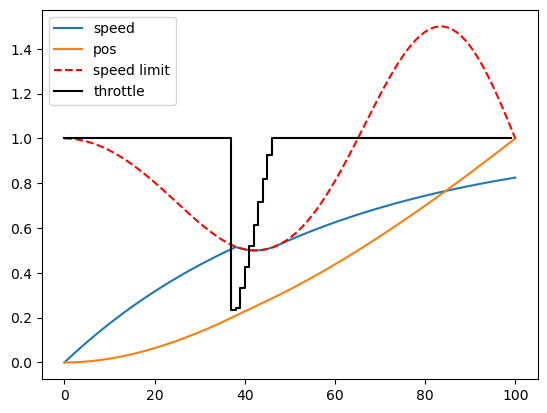

In [136]:
# Car race along a track
# ----------------------
# An optimal control problem (OCP),
# solved with direct multiple-shooting.
#
# For more information see: http://labs.casadi.org/OCP
from casadi import *

N = 100 # number of control intervals

opti = Opti() # Optimization problem

# ---- decision variables ---------
X = opti.variable(2,N+1) # state trajectory
pos   = X[0,:]
speed = X[1,:]
U = opti.variable(1,N)   # control trajectory (throttle)
T = opti.variable()      # final time

# ---- objective          ---------
opti.minimize(T) # race in minimal time

# ---- dynamic constraints --------
f = lambda x,u: vertcat(x[1],u-x[1]) # dx/dt = f(x,u)

dt = T/N # length of a control interval
for k in range(N): # loop over control intervals
   # Runge-Kutta 4 integration
   k1 = f(X[:,k],            U[:,k])
   k2 = f(X[:,k]+ dt/2 * k1, U[:,k])
   k3 = f(X[:,k]+ dt/2 * k2, U[:,k])
   k4 = f(X[:,k]+ dt * k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # close the gaps

# ---- path constraints -----------
limit = lambda pos: 1-sin(2*pi*pos)/2
opti.subject_to(speed<=limit(pos))   # track speed limit
opti.subject_to(opti.bounded(0,U,1)) # control is limited

# ---- boundary conditions --------
opti.subject_to(pos[0]==0)   # start at position 0 ...
opti.subject_to(speed[0]==0) # ... from stand-still 
opti.subject_to(pos[-1]==1)  # finish line at position 1

# ---- misc. constraints  ----------
opti.subject_to(T>=0) # Time must be positive

# ---- initial values for solver ---
opti.set_initial(speed, 1)
opti.set_initial(T, 1)

# ---- solve NLP              ------
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve

# ---- post-processing        ------
from pylab import plot, step, figure, legend, show, spy

plot(sol.value(speed),label="speed")
plot(sol.value(pos),label="pos")
plot(limit(sol.value(pos)),'r--',label="speed limit")
step(range(N),sol.value(U),'k',label="throttle")
legend(loc="upper left")

show()